In [60]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)
print(tf.config.list_physical_devices('GPU'))

2.20.0
3.13.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [61]:
from PIL import Image

img = Image.open("data/almond_mushroom/0.png")
print(img.size)

(512, 512)


In [62]:
data_dir = "data"

# Add data augmentation to combat overfitting
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal_and_vertical"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.1),
        keras.layers.RandomBrightness(0.1),
        keras.layers.RandomContrast(0.1),
    ]
)

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(128, 128),
    batch_size=64,
)

# Save class_names before transformations
class_names = train_ds.class_names
print(class_names)
print("There are", len(class_names), "classes")

# Apply data augmentation to training data
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 3122 files belonging to 215 classes.
Using 2498 files for training.
Using 624 files for validation.
['almond_mushroom', 'amanita_gemmata', 'amethyst_chanterelle', 'amethyst_deceiver', 'aniseed_funnel', 'ascot_hat', 'bay_bolete', 'bearded_milkcap', 'beechwood_sickener', 'beefsteak_fungus', 'birch_polypore', 'birch_woodwart', 'bitter_beech_bolete', 'bitter_bolete', 'black_bulgar', 'black_morel', 'blackening_brittlegill', 'blackening_polypore', 'blackening_waxcap', 'blue_roundhead', 'blushing_bracket', 'blushing_rosette', 'blushing_wood_mushroom', 'bovine_bolete', 'bronze_bolete', 'brown_birch_bolete', 'brown_rollrim', 'bruising_webcap', 'butter_cap', 'cauliflower_fungus', 'cedarwood_waxcap', 'chanterelle', 'charcoal_burner', 'chestnut_bolete', 'chicken_of_the_woods', 'cinnamon_bracket', 'clouded_agaric', 'clustered_domecap', 'common_bonnet', 'common_inkcap', 'common_morel', 'common_puffball', 'common_rustgill', 'crimped_gill', 'crimson_waxcap', 'cucumber_cap', 'curry_milkcap', 'dea

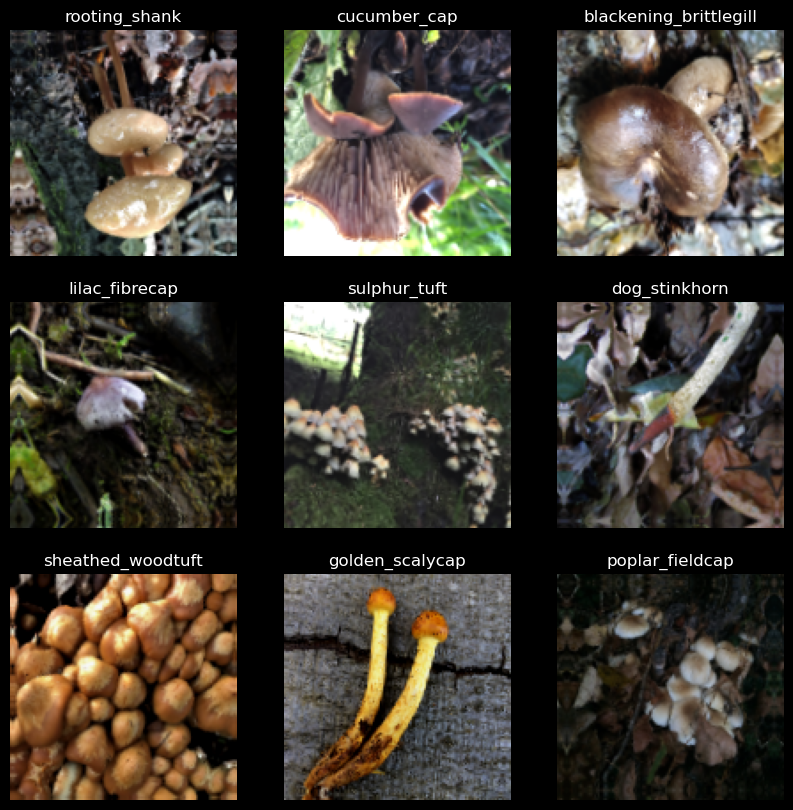

2026-02-02 00:47:26.242459: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [63]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

In [64]:
from keras.models import Sequential
from keras.layers import (
    Input,
    Rescaling,
    GlobalAveragePooling2D,
    Dense,
    Dropout,
)
from keras.applications import MobileNetV2

# Load pretrained MobileNetV2
base_model = MobileNetV2(
    input_shape=(128, 128, 3), include_top=False, weights="imagenet"
)
base_model.trainable = False  # Freeze base model

# Get number of classes from train_ds
num_classes = len(class_names)

model = Sequential(
    [
        Input(shape=(128, 128, 3)),
        Rescaling(1.0 / 255),
        
        # MobileNetV2 base
        base_model,
        
        # Pool and flatten
        GlobalAveragePooling2D(),
        
        # Dense layers with dropout
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax'),
    ]
)

model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 215)            │        27,735 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,449,687 (9.34 MB)

 Trainable params: 191,703 (748.84 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [65]:
from keras.callbacks import ReduceLROnPlateau

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [66]:
history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=50,
    callbacks=[reduce_lr]
)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 328ms/step - accuracy: 0.0056 - loss: 5.5032 - val_accuracy: 0.0112 - val_loss: 5.3559 - learning_rate: 0.0010
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.0144 - loss: 5.3226 - val_accuracy: 0.0176 - val_loss: 5.3107 - learning_rate: 0.0010
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.0260 - loss: 5.2059 - val_accuracy: 0.0369 - val_loss: 5.1931 - learning_rate: 0.0010
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.0504 - loss: 4.9839 - val_accuracy: 0.0625 - val_loss: 4.9869 - learning_rate: 0.0010
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.0797 - loss: 4.6414 - val_accuracy: 0.0833 - val_loss: 4.6769 - learning_rate: 0.0010
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.1177 - loss: 4.3413 - val_accuracy: 0.1282 - val_loss: 4.3384 - learning_rate: 0.0010
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.1477 - loss: 4.0218 -

# Plot traning history

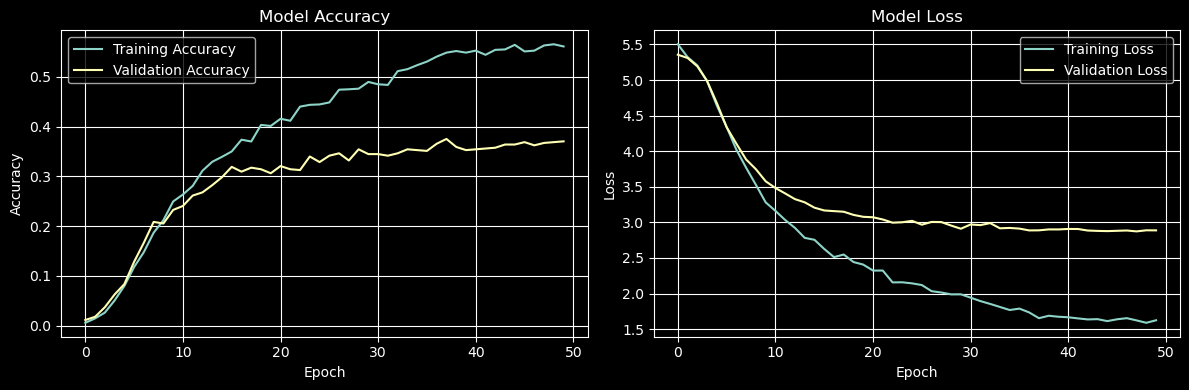

In [68]:
# Plot training history to visualize overfitting
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [69]:
# Save the model after training
model.save("mushroom_model.keras")
print("Model saved as 'mushroom_model.keras'")

Model saved as 'mushroom_model.keras'
